In [1]:
import cantera as ct
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

## Thermo Data

When loading a CTI file, sometimes you will encounter warnings about discontinuities in the thermodynamic data.

In [2]:
gas = ct.Solution("/home/derek/Documents/IgnitionProject/BioPOx.cti")

For species CELLA, discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  45.739067100000014
	Value computed using high-temperature polynomial: 46.611177261499996

For species CELLA, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -75.68230054166666
	Value computed using high-temperature polynomial: -75.8251419842

For species CELL, discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  45.739067100000014
	Value computed using high-temperature polynomial: 46.611177261499996

For species CELL, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -75.68230054166666
	Value computed using high-temperature polynomial: -75.8251419842

For species C6H10O5, discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  45.739067100000014
	Value computed using high-temperature 

These warnings are part of a validation check that Cantera does to make sure the thermodynamics data are consistent. In the standard NASA 14-coefficient polynomial form, the thermodynamics data are defined as two five coefficient polynomials (plus two other constants) over two temperature ranges. This is the form used for CHEMKIN files. The discontinuities occur when either the slope or the value of the thermodynamic functions ($c_p/R$, $h/(RT)$, or $s/R$) has a discontinuity at the mid-point temperature. Most commonly, one or more the discontinuities are due to incorrectly fit parameters, but they can also be caused by other means. Let's investigate.

In [3]:
ct.suppress_thermo_warnings()

<IPython.core.display.Javascript object>


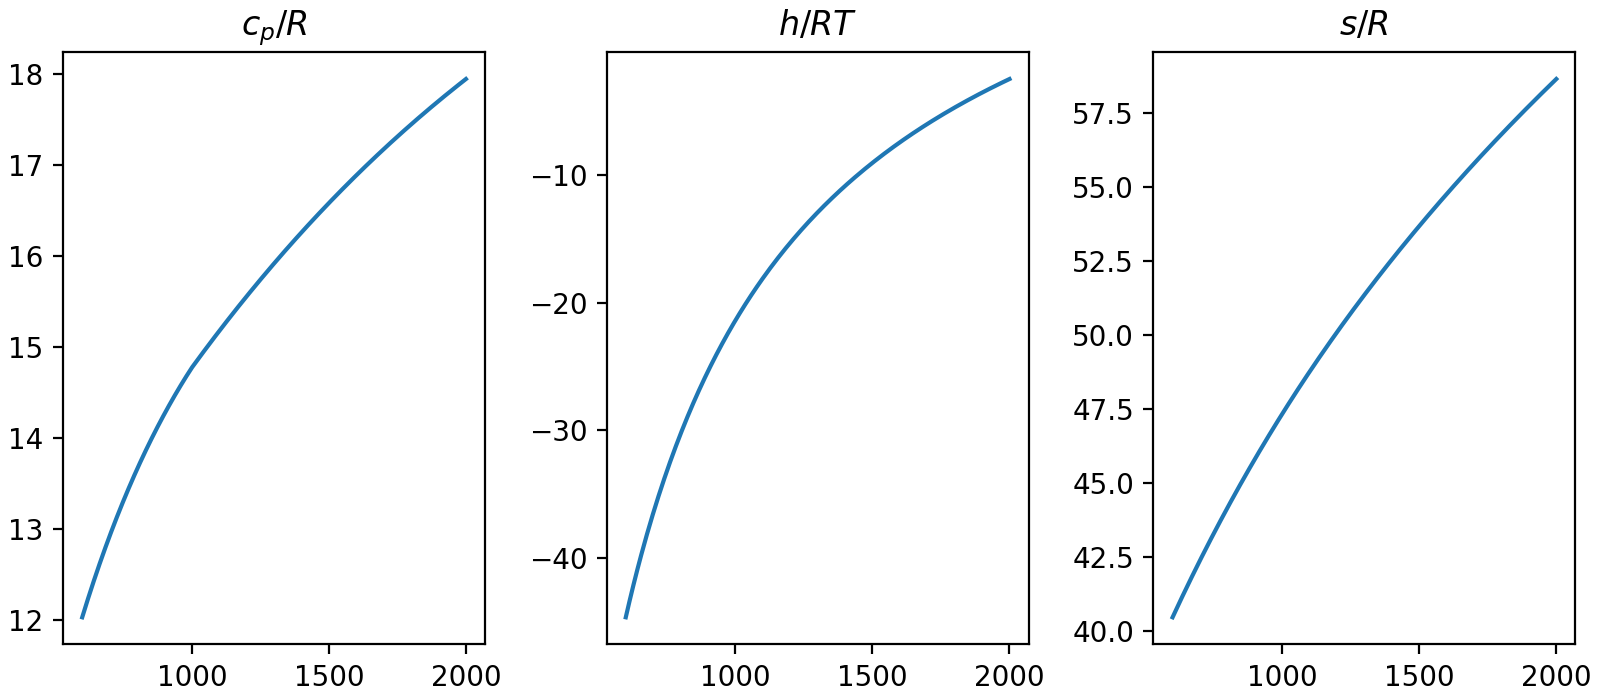

In [26]:
sp = gas.species('R23C2H3O2B')
T = np.linspace(600, 2000, 200)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(sp.thermo)

In [19]:
c0 = sp.thermo.coeffs
c0

array([ 1.0000000e+03,  4.3148279e+00,  1.3877206e-02, -5.1784232e-06,
        8.8229646e-10, -5.6921298e-14, -8.6852227e+03, -4.3943405e-01,
       -9.2033523e-01,  2.6421962e-02, -1.3407433e-05,  3.1399369e-10,
        1.4228568e-12, -7.1333140e+03,  2.7113031e+01])

In [20]:
c0[0] = 1200
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In [21]:
c0[0] = 1000
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In many cases, when the change is on the order of a few percent, these discontinuities won't cause problems. However, if you notice a simulation failing at a consistent temperature for several conditions, this is one possible cause.

## Reaction Rates

Another common issue with mechanisms are unphysical reaction rates (particularly reverse reaction rates). These unphysical reaction rates often exceed the collision limit for a given reaction. A recent study by [Chen et al.](https://www.sciencedirect.com/science/article/pii/S0010218017303024) found that

> among.. 20 [recent] models tested, 15 of them contain either considerable numbers of rate coefficients that exceed their respective collision limits or reactions exceeding the collision limit in a considerable manner. In the worst case, the rate coefficient exceeds the collision limit by 73 orders of magnitude.

The authors continue

> It is proposed that computational tools should be made available for authors to conduct the same rate coefficient screening.

Let's take a look at how Cantera can fill this need.

In [9]:
gas.TPX = 300, 101325, 'CH4:1.0, O2:0.1'
gas.equilibrate('TP')
gas()


  gas:

       temperature   300 K
          pressure   1.0132e+05 Pa
           density   0.68972 kg/m^3
  mean mol. weight   16.979 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        -1.424e+07       -2.4179e+08  J
   internal energy       -1.4387e+07       -2.4428e+08  J
           entropy             11450        1.9442e+05  J/K
    Gibbs function       -1.7676e+07       -3.0011e+08  J
 heat capacity c_p            1971.8             33479  J/K
 heat capacity c_v            1482.1             25164  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             ACQUA          0.061735          0.058185            -122.5
             G{CO}          0.097041          0.058824           -122.49
            G{CO2}        1.1289e-09        4.3555e-10           -205.04
 

<IPython.core.display.Javascript object>


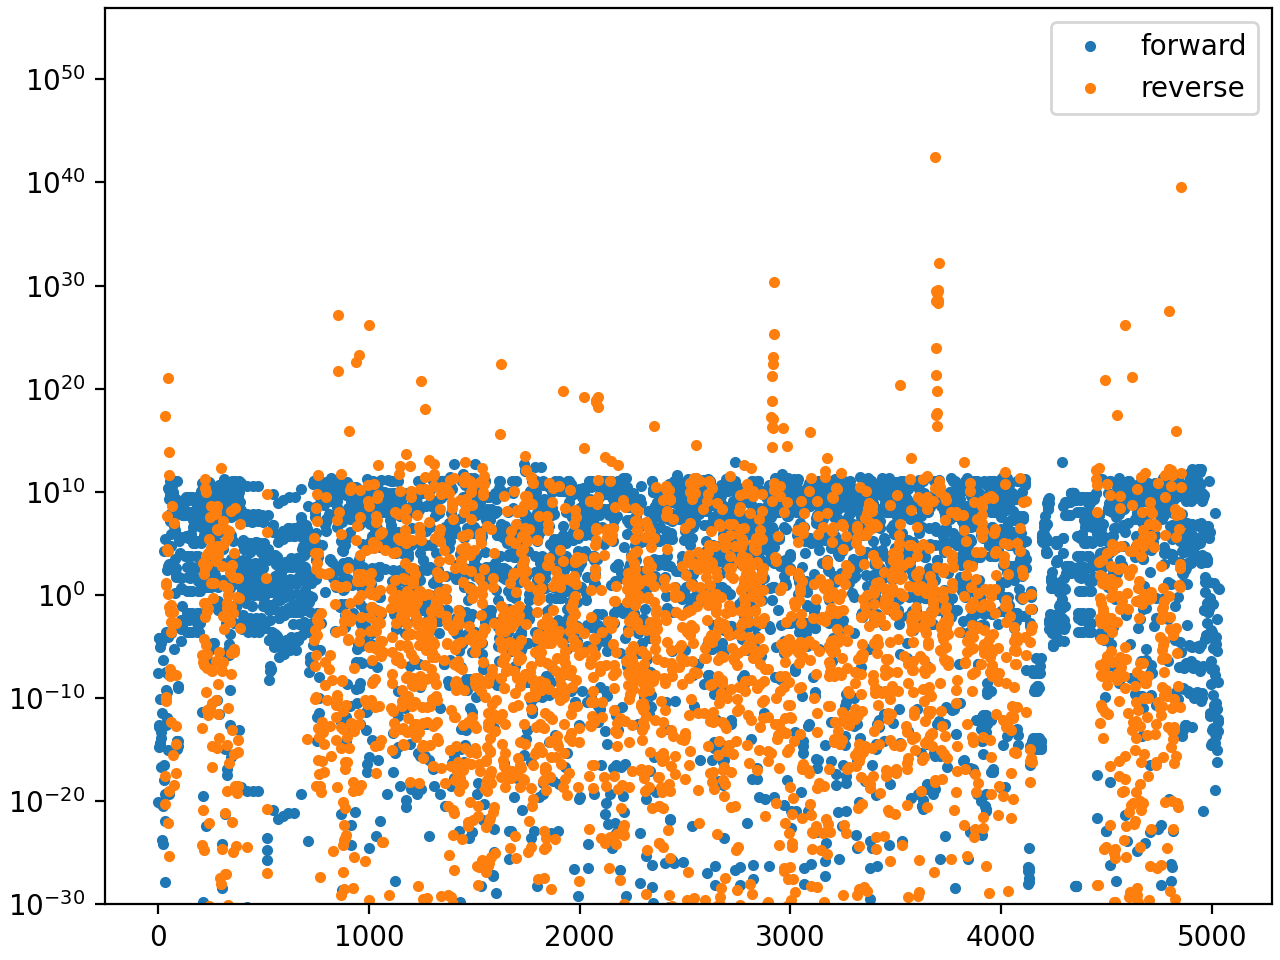

In [10]:
f, ax = plt.subplots()
ax.semilogy(gas.forward_rate_constants, '.', label='forward')
ax.semilogy(gas.reverse_rate_constants, '.', label='reverse')
ax.axis(ymin=1e-30)
ax.legend();

There are clearly several reverse rates with very high magnitudes. Let's print the reactions with reverse rate constants higher than $10^{20}$:

In [11]:
kr = gas.reverse_rate_constants
for i, k in enumerate(kr):
    if k > 1e20:
        print(f'{i:4d}  {k:.4e}  {gas.reaction_equation(i)}')

  49  1.1191e+21  M5F-2ylO <=> B2CO + C2H2T + R14CH3CO
 854  1.3936e+27  CH2COZ + M <=> B2CO + B6CH2 + M
 855  5.4872e+21  CH2COZ + M <=> R12CHCOV + R1H + M
 937  3.8174e+22  C2H2T + R8CH3OO <=> CH3OOH + R9C2HT
 955  2.0300e+23  C2H2T + R17C2H5OO <=> C2H5OOH + R9C2HT
 999  1.4413e+26  C2H3CHOZ + O2 <=> B2CO + R10C2H3V + R3OOH
1246  5.7764e+20  CH3C6H4CH2OH + O2 <=> CH3C6H4CH2O + R3OOH
1625  2.5204e+22  MEF + R2OH <=> CH3(CO)C2H3 + RC3H5O
2914  1.8252e+21  C2H5CHO + R3OOH <=> H2O2 + RC3H5O
2916  2.5504e+22  C2H5CHO + R8CH3OO <=> CH3OOH + RC3H5O
2919  1.1468e+23  C2H5CHO + R17C2H5OO <=> C2H5OOH + RC3H5O
2920  2.4129e+30  C2H5CHO + O2 <=> R3OOH + RC3H5O
2923  1.8620e+25  B2CO + R11C2H5 <=> RC3H5O
3522  2.3498e+20  C6H7# <=> lC6H7
3686  2.9004e+42  C6H5CH2OH + O2 <=> C6H5CHOH + R3OOH
3689  9.1456e+23  C6H5CH2OH + R1H <=> C6H5CHOH + H2
3690  3.2154e+28  B1O + C6H5CH2OH <=> C6H5CHOH + R2OH
3692  2.9254e+29  C6H5CH2OH + R3OOH <=> C6H5CHOH + H2O2
3693  2.0426e+21  C6H5CH2OH + R4CH3 <=> C6H5CHO

Among these is the reaction 

$$\text{CH}_3 + \text{M} <=> \text{CH} + \text{H}_2 + \text{M}$$

with reverse rate constant of `4.2656e+23`. This is a pretty common reaction, so we can compare to the same reaction from, for example, GRI 3.0:

In [12]:
gri = ct.Solution('gri30.cti')
for i, r in enumerate(gri.reactions()):
    if 'CH3' in r and 'H2' in r and 'CH' in r:
        print(i, r)

288 CH + H2 (+M) <=> CH3 (+M)


The reaction is #295 from the first mechanism and #288 from GRI-30, so we can calculate the rate of each reaction over a range of temperatures from 300 K to 3000 K and plot them.

<IPython.core.display.Javascript object>


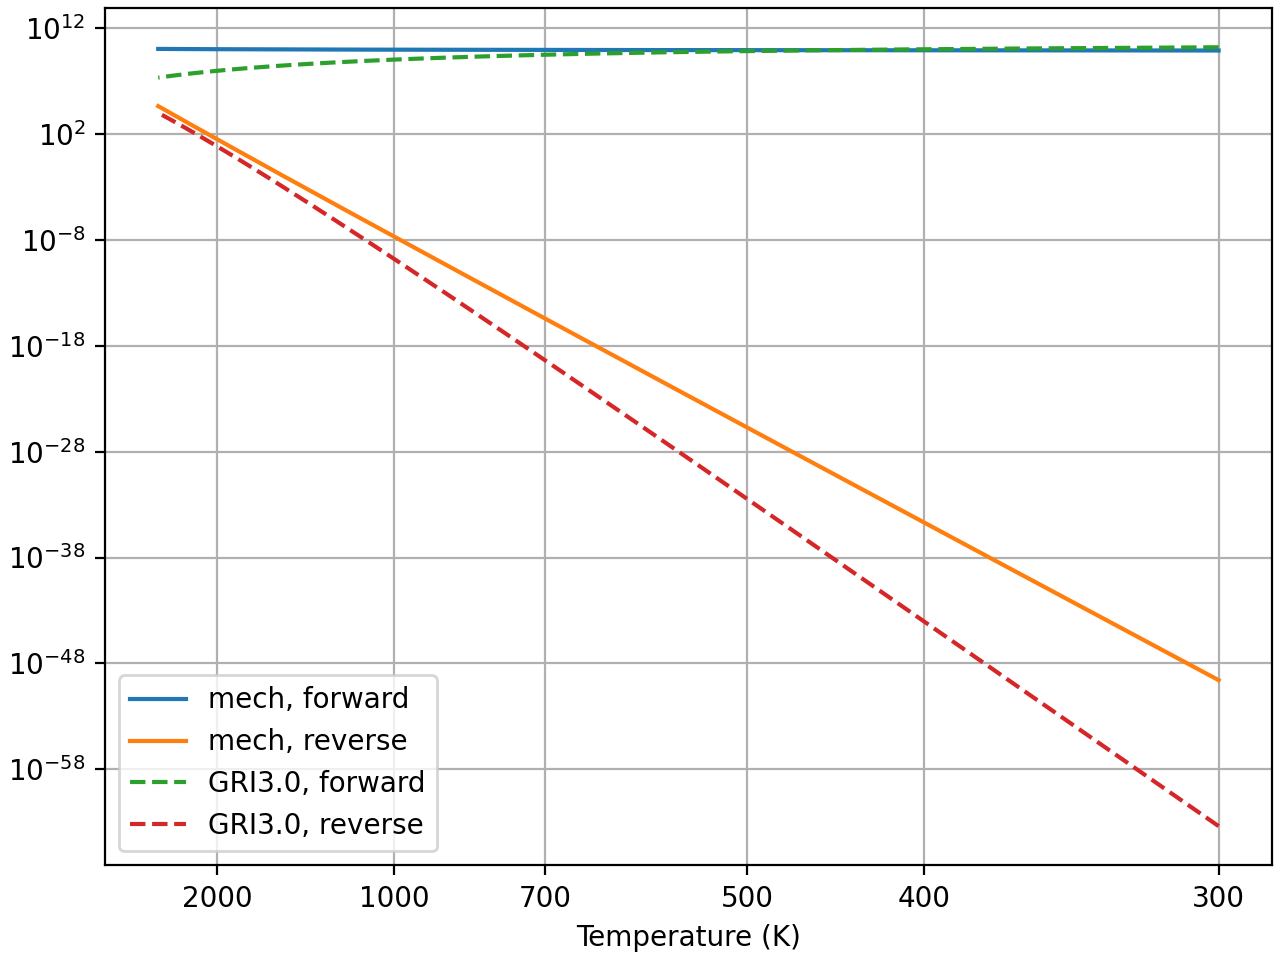

In [13]:
gasN = ct.SolutionArray(gas, shape=200)
griN = ct.SolutionArray(gri, shape=200)
T = np.linspace(300, 3000, 200)
gasN.TPY = T, ct.one_atm, 'N2:1.0'
griN.TPY = T, ct.one_atm, 'N2:1.0'

f,ax = plt.subplots()
ax.semilogy(1000/T, gasN.forward_rate_constants[:,295], label='mech, forward')
ax.semilogy(1000/T, gasN.reverse_rate_constants[:,295], label='mech, reverse')
ax.semilogy(1000/T, griN.forward_rate_constants[:,288], '--', label='GRI3.0, forward')
ax.semilogy(1000/T, griN.reverse_rate_constants[:,288], '--', label='GRI3.0, reverse')
T_label = np.array([300, 400, 500, 700, 1000, 2000])
ax.set(xticks=1000/T_label, xticklabels=T_label, xlabel='Temperature (K)')
ax.legend()
ax.grid(True)

Here, we see that the rate of the reactions is close-ish at high temperature (>1000 K), but as the temperature decreases, they rapidly diverge and differ by 11 orders of magnitude at 300 K. This can cause problems in the integrator for both 0-D and 1-D problems, often accompanied by error messages about "Repeated recoverable right-hand side errors"